<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 2: Geospatial Data in Python</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bC/lab_C.html
* Automating GIS-Processes: https://autogis-site.readthedocs.io/en/latest/notebooks/L2/02-projections.html

# PART 1: Data Inspection

## Imports

In [1]:
import geopandas as gpd # for geospatial data handling
import osmnx # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting

In [2]:
osmnx.config(
    overpass_settings='[out:json][timeout:90][date:"2020-09-07T00:00:00Z"]'
)

/tmp/ipykernel_181846/3277903806.py:1: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  osmnx.config(


In this lecture, we will learn how to load, manipulate and visualize spatial data. In some senses, spatial data are usually included simply as "one more column" in a table. However, *spatial is special* sometimes and there are few aspects in which geographic data differ from standard numerical tables. Dealing with spatial data in Python largely resembles dealing with non-spatial data.

## Introduction to GeoPandas

There are various different GIS data formats available such as [Shapefile](https://en.wikipedia.org/wiki/Shapefile), [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON), [KML](https://en.wikipedia.org/wiki/Keyhole_Markup_Language), and [GPKG](https://en.wikipedia.org/wiki/GeoPackage). [Geopandas](https://geopandas.org/en/stable/docs/user_guide/io.html) is capable of reading data from all of these formats (plus many more), and it combines the capabilities of the data analysis library [pandas](https://pandas.pydata.org/pandas-docs/stable/) with other packages like [shapely](https://shapely.readthedocs.io/en/stable/manual.html) and [fiona](https://fiona.readthedocs.io/en/latest/manual.html) for managing spatial data. 

The main data structures in geopandas are `GeoSeries` and `GeoDataFrame` which extend the capabilities of `Series` and `DataFrames` from pandas. This means that we can use all our pandas skills also when working with geopandas!

The main difference between geodataframes and pandas dataframes is that a [geodataframe](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geodataframe) should contain one column for geometries. By default, the name of this column is `'geometry'`. The geometry column is a [geoseries](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geoseries) which contains the geometries (points, lines, polygons, multipolygons etc.) as shapely objects. More info here: https://geopandas.org/en/stable/getting_started/introduction.html

<img src="files/dataframe.svg">

## Datasets

To learn these concepts, we will be playing with three main datasets: Cities, streets, and bars in Spain. These datasets can be loaded dynamically from the web, or from your computer.

### Cities

First we will use a polygon object. We will use an open dataset that contains the boundaries of Spanish cities. We can read it into an object named `cities` by:

In [3]:
cities = gpd.read_file("https://ndownloader.figshare.com/files/20232174")

The code cell above requires internet connectivity. If you are not online you can read the data from your computer with the following line of code: 

In [4]:
cities = gpd.read_file("files/cities.gpkg")

---

### Streets

This dataset froms of a project called "Las calles de las mujeres", a community-driven initiative exploring the extent to which streets are named after women. 

Check out more about the project, including an interactive map at: [https://geochicasosm.github.io/lascallesdelasmujeres/](https://geochicasosm.github.io/lascallesdelasmujeres/)

In addition to polygons, we will play with a line layer. For that, we are going to use a subset of street network from the Spanish city of Madrid. 

The data is available on the following web address:

In [5]:
url = (
    "https://github.com/geochicasosm/lascallesdelasmujeres"
    "/raw/master/data/madrid/final_tile.geojson"
)
url

'https://github.com/geochicasosm/lascallesdelasmujeres/raw/master/data/madrid/final_tile.geojson'

And you can read it into an object called `streets` with:

In [6]:
streets = gpd.read_file(url)

---

The code cell above requires internet connectivity. If you are not online, you can read the data with the following line of code: 

In [7]:
streets = gpd.read_file("files/streets.geojson")

---

### Bars

The final dataset we will rely on is a set of points demarcating the location of bars in Madrid. To obtain it, we will use `osmnx`, a Python library that allows us to query [OpenStreetMap](https://www.openstreetmap.org). Note that we use the method `pois_from_place`, which queries for points of interest (POIs, or `pois`) in a particular place (Madrid in this case). In addition, we can specify a set of tags to delimit the query. We use this to ask _only_ for amenities of the type "bar":

In [8]:
pois = osmnx.geometries_from_place(
    "Madrid, Spain", tags={"amenity": "bar"}
)

/tmp/ipykernel_181846/1402187098.py:1: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = osmnx.geometries_from_place(


You do not need to know at this point what happens behind the scenes when we run `geometries_from_place` but, if you are curious, we are making a query to [OpenStreetMap](https://www.openstreetmap.org) (almost as if you typed "bars in Madrid, Spain" within Google Maps) and getting the response as a table of data, instead of as a website with an interactive map. Pretty cool, huh?

---

## Inspecting spatial data

The most direct way to get from a file to a quick visualization of the data is by loading it as a `GeoDataFrame` and calling the `plot` command. 

In two lines of code, we will obtain a graphical representation of the spatial data contained in a file that can be in many formats; actually, since it uses the same drivers under the hood, you can load pretty much the same kind of vector files that Desktop GIS packages like QGIS permit. Let us start by plotting single layers in a crude but quick form, and we will build style and sophistication into our plots later on.

### Polygons

Now `cities` is a `GeoDataFrame`. Very similar to a traditional, non-spatial `DataFrame`, but with an additional column called `geometry`:

In [9]:
cities.head()

,city_id,n_buildings,geometry
0,ci000,2348,"POLYGON ((385390.071 4202949.446, 384488.697 4..."
1,ci001,2741,"POLYGON ((214893.033 4579137.558, 215258.185 4..."
2,ci002,5472,"POLYGON ((690674.281 4182188.538, 691047.526 4..."
3,ci003,14608,"POLYGON ((513378.282 4072327.639, 513408.853 4..."
4,ci004,2324,"POLYGON ((206989.081 4129478.031, 207275.702 4..."


This allows us to quickly produce a plot by executing the following line:

<Axes: >

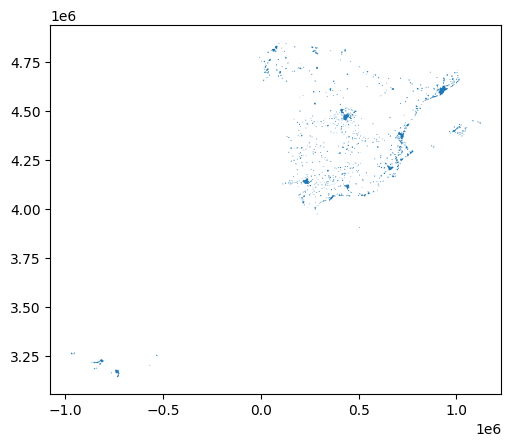

In [10]:
cities.plot()

This might not be the most aesthetically pleasant visual representation of cities, but it is hard to argue it is not quick to produce. We will work on styling and customizing spatial plots later on.

**Pro-tip**: if you call a single row of the `geometry` column, it'll return a small plot with the shape:

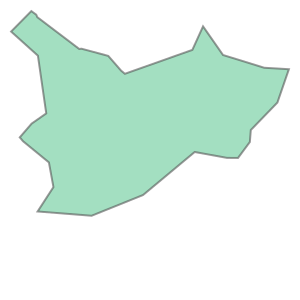

In [11]:
cities.loc[0, 'geometry']

### Lines

Similarly to the polygon case, if we pick the `"geometry"` column of a table with lines, a single row will display the geometry as well:

In [ ]:
streets.head()

In [ ]:
streets.loc[2, 'geometry']

A quick plot is similarly generated by:

In [ ]:
streets.plot()

Again, this is not the prettiest way to display the streets maybe, and you might want to change a few parameters such as colors, etc. All of this is possible, as we will see below, but this gives us a quick check of what lines look like.

### Points

Points take a similar approach for quick plotting:

In [ ]:
pois.head()

In [ ]:
pois.plot()

## Styling plots

It is possible to tweak several aspects of a plot to customize if to particular needs. In this section, we will explore some of the basic elements that will allow us to obtain more compelling maps.

**NOTE**: some of these variations are very straightforward while others are more intricate and require tinkering with the internal parts of a plot. They are not necessarily organized by increasing level of complexity.

### Changing transparency

The intensity of color of a polygon can be easily changed through the `alpha` attribute in plot. This is specified as a value betwee zero and one, where the former is entirely transparent while the latter is the fully opaque (maximum intensity):

In [ ]:
pois.plot(alpha=0.1)

### Removing axes

Although in some cases, the axes can be useful to obtain context, most of the times maps look and feel better without them. Removing the axes involves wrapping the plot into a figure, which takes a few more lines of aparently useless code but that, in time, it will allow you to tweak the map further and to create much more flexible designs:

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Plot layer of polygons on the axis
cities.plot(ax=ax)
# Remove axis frames
ax.set_axis_off()
# Display
plt.show()

Let us stop for a second a study each of the previous lines:

1. We have first created a figure named `f` with one axis named `ax` by using the command `plt.subplots` (part of the library `matplotlib`, which we have imported at the top of the notebook). Note how the method is returning two elements and we can assign each of them to objects with different name (`f` and `ax`) by simply listing them at the front of the line, separated by commas.
1. Second, we plot the geographies as before, but this time we tell the function that we want it to draw the polygons on the axis we are passing, `ax`. This method returns the axis with the geographies in them, so we make sure to store it on an object with the same name, `ax`.
1. On the third line, we effectively remove the box with coordinates.
1. Finally, we draw the entire plot by calling `plt.show()`.

### Adding a title

Adding a title is an extra line, if we are creating the plot within a figure, as we just did. To include text on top of the figure:

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add layer of polygons on the axis
streets.plot(ax=ax)
# Add figure title
f.suptitle("Streets in Madrid")
# Display
plt.show()

### Changing the size of the map

The size of the plot is changed equally easily in this context. The only difference is that it is specified when we create the figure with the argument `figsize`. The first number represents the width, the X axis, and the second corresponds with the height, the Y axis.

In [ ]:
# Setup figure and axis with different size
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis
cities.plot(ax=ax)
# Display
plt.show()

### Modifying borders

Border lines sometimes can distort or impede proper interpretation of a map. In those cases, it is useful to know how they can be modified. Although not too complicated, the way to access borders in `geopandas` is not as straightforward as it is the case for other aspects of the map, such as size or frame. Let us first see the code to make the *lines thicker* and *black*, and then we will work our way through the different steps:

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis, set fill color (`facecolor`) and boundary
# color (`edgecolor`)
cities.plot(
    linewidth=1, 
    facecolor='red', 
    edgecolor='black', 
    ax=ax
);

Note how the lines are thicker. In addition, all the polygons are colored in the same (default) color, light red. However, because the lines are thicker, we can only see the polygon filling for those cities with an area large enough.

Let us examine line by line what we are doing in the code snippet:

* We begin by creating the figure (`f`) object and one axis inside it (`ax`) where we will plot the map.
* Then, we call `plot` as usual, but pass in two new arguments: `linewidth` for the width of the line; `facecolor`, to control the color each polygon is filled with; and `edgecolor`, to control the color of the boundary.

This approach works very similarly with other geometries, such as lines. For example, if we wanted to plot the streets in red, we would simply:

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add layer with lines, set them red and with different line width
# and append it to the axis `ax`
streets.plot(linewidth=2, color='red', ax=ax)

Important, note that in the case of lines the parameter to control the color is simply `color`. This is because lines do not have an area, so there is no need to distinguish between the main area (`facecolor`) and the border lines (`edgecolor`).

### Transforming CRS

The coordindate reference system (CRS) is the way geographers and cartographers have to represent a three-dimensional object, such as the round earth, on a two-dimensional plane, such as a piece of paper or a computer screen. If the source data contain information on the CRS of the data, we can modify this in a `GeoDataFrame`. In particular, if we have multiple data sets that should be analyzed or plotted together, they need to be in the same CRS.

In [ ]:
print(cities.crs.to_epsg())
print(streets.crs.to_epsg())
print(pois.crs.to_epsg())

In [ ]:
cities.crs

As we can see, there is information stored about the reference system: it is using the standard Spanish projection, which is expressed in meters. There are also other less decipherable parameters but we do not need to worry about them right now.

If we want to modify this and "reproject" the polygons into a different CRS, the quickest way is to find the [EPSG](https://en.wikipedia.org/wiki/International_Association_of_Oil_%26_Gas_Producers#European_Petroleum_Survey_Group) code online ([epsg.io](http://epsg.io/) is a good one, although there are others too). For example, if we wanted to transform the dataset into lat/lon coordinates, we would use its EPSG code, 4326:

In [ ]:
# Reproject (`to_crs`) and plot (`plot`) polygons
cities.to_crs(epsg=4326).plot()
# Set equal axis
lims = plt.axis('equal')

The shape of the polygons is slightly different. Furthermore, note how the *scale* in which they are plotted differs.

## Composing multi-layer maps

So far we have considered many aspects of plotting *a single* layer of data. However, in many cases, an effective map will require more than one: for example we might want to display streets on top of the polygons of neighborhoods, and add a few points for specific locations we want to highlight. At the very heart of GIS is the possibility to combine spatial information from different sources by overlaying it on top of each other, and this is fully supported in Python.

For this section, let's select only Madrid from the `cities` table and convert it to lat/lon so it's aligned with the streets and POIs layers:

In [ ]:
mad = cities.loc[[12], :].to_crs(epsg=4326)
mad

Combining different layers on a single map boils down to adding each of them to the same axis in a sequential way, as if we were literally overlaying one on top of the previous one. For example, let's plot the boundary of Madrid and its bars:

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
mad.plot(ax=ax, color="yellow")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, color="green")

## Saving maps to figures

Once we have produced a map we are content with, we might want to save it to a file so we can include it into a report, article, website, etc. Exporting maps in Python involves replacing `plt.show` by `plt.savefig` at the end of the code block to specify where and how to save it. For example to save the previous map into a `png` file in the same folder where the notebook is hosted:

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
mad.plot(ax=ax, color="yellow")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, color="green")
# Save figure to a PNG file
plt.savefig('madrid_bars.png')

If you now check on the folder, you'll find a `png` (image) file with the map.

The command `plt.savefig` contains a large number of options and additional parameters to tweak. Given the size of the figure created is not very large, we can increase this with the argument `dpi`, which stands for "dots per inch" and it's a standard measure of resolution in images. For example, for a high quality image, we could use 500:

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
mad.plot(ax=ax, color="yellow")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, color="green")
# Save figure to a PNG file
plt.savefig('madrid_bars.png', dpi=500)

## Manipulating spatial tables (`GeoDataFrames`)

Once we have an understanding of how to visually display spatial information contained, let us see how it can be combined with the operations learnt in the previous session about manipulating non-spatial tabular data. Essentially, the key is to realize that a `GeoDataFrame` contains most of its spatial information in a single column named `geometry`, but the rest of it looks and behaves exactly like a non-spatial `DataFrame` (in fact, it is). 

`GeoDataFrame`s come with a whole range of traditional GIS operations built-in. Here we will run through a small subset of them that contains some of the most commonly used ones.

### Area calculation

One of the spatial aspects we often need from polygons is their area. "How big is it?" is a question that always haunts us when we think of countries, regions, or cities. To obtain area measurements, first make sure your `GeoDataFrame` is projected. If that is the case, you can calculate areas as follows:

In [ ]:
city_areas = cities.area
city_areas.head()

This indicates that the area of the first city in our table takes up 8,450,000 squared metres. If we wanted to convert into squared kilometres, we can divide by 1,000,000:

In [ ]:
areas_in_sqkm = city_areas / 1000000
areas_in_sqkm.head()

### Length

Similarly, an equally common question with lines is their length. Also similarly, their computation is relatively straightforward in Python, provided that our data are projected. Here we will perform the projection (`to_crs`) and the calculation of the length at the same time:

In [ ]:
street_length = streets.to_crs(epsg=25830).length
street_length.head()

Since the CRS we use (`EPSG:25830`) is expressed in metres, we can tell the first street segment is about 37m.

### Centroid calculation

Sometimes it is useful to summarize a polygon into a single point and, for that, a good candidate is its centroid (almost like a spatial analogue of the average). The following command will return a `GeoSeries` (a single column with spatial data) with the centroids of a polygon `GeoDataFrame`:

In [ ]:
cents = cities.centroid
cents.head()

Note how `cents` is not an entire table but a single column, or a `GeoSeries` object. This means you can plot it directly, just like a table:

In [ ]:
cents.plot()

But you don't need to call a `geometry` column to inspect the spatial objects. In fact, if you do it will return an error because there is not any `geometry` column, the object `cents` itself is the geometry.

### Point in polygon (PiP)

Knowing whether a point is inside a polygon is conceptually a straightforward exercise but computationally a tricky task to perform. The way to perform this operation in `GeoPandas` is through the `contains` method, available for each polygon object.

In [ ]:
poly = cities.loc[12, "geometry"]
pt1 = cents[0]
pt2 = cents[12]

And we can perform the checks as follows:

In [ ]:
poly.contains(pt1)

In [ ]:
poly.contains(pt2)

Performing point-in-polygon in this way is instructive and useful for pedagogical reasons, but for cases with many points and polygons, it is not particularly efficient. In these situations, it is much more advisable to perform then as a "spatial join". If you are interested in these, see this link to learn more about them:
https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins

### Buffers

Buffers are one of the classical GIS operations in which an area is drawn around a particular geometry, given a specific radious. These are very useful, for instance, in combination with point-in-polygon operations to calculate accessibility, catchment areas, etc.

For this example, we will use the bars table, but will project it to the same CRS as `cities`, so it is expressed in metres:

In [ ]:
pois_projected = pois.to_crs(cities.crs)
pois_projected.crs

To create a buffer using `geopandas`, simply call the `buffer` method, passing in the radious. For example, to draw a 500m. buffer around every bar in Madrid:

In [ ]:
buf = pois_projected.buffer(500)
buf.head()

And plotting it is equally straighforward:

In [ ]:
f, ax = plt.subplots(1)
# Plot buffer
buf.plot(ax=ax, linewidth=0)
# Plot named places on top for reference
# [NOTE how we modify the dot size (`markersize`)
# and the color (`color`)]
pois_projected.plot(ax=ax, markersize=1, color='yellow')

## Adding base layers from web sources

Many single datasets lack context when displayed on their own. A common approach to alleviate this is to use web tiles, which are a way of quickly obtaining geographical context to present spatial data. In Python, we can use [`contextily`](https://contextily.readthedocs.io) to pull down tiles and display them along with our own geographic data.

We can begin by creating a map in the same way we would do normally, and then use the `add_basemap` command to, er, add a basemap:

In [ ]:
ax = cities.plot(color="red")
cx.add_basemap(ax);

Oops, something went wrong! Let us fix it:

In [ ]:
ax = cities.plot(color="black")
cx.add_basemap(ax, crs=cities.crs);

We need to be explicit when adding the basemap to state the coordinate reference system (`crs`) our data is expressed in, `contextily` will not be able to pick it up otherwise. Conversely, we could change our data's CRS into [Pseudo-Mercator](http://epsg.io/3857), the native reference system for most web tiles:

In [ ]:
cities_wm = cities.to_crs(epsg=3857)
ax = cities_wm.plot(color="black")
cx.add_basemap(ax);

Note how the coordinates are different but, if we set it right, either approach aligns tiles and data nicely.

Web tiles can be integrated with other features of maps in a similar way as we have seen above. So, for example, we can change the size of the map, and remove the axis. Let's use Madrid for this example:

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
mad.plot(alpha=0.25, ax=ax)
cx.add_basemap(ax, crs=mad.crs)
ax.set_axis_off()

Now, `contextily` offers a lot of options in terms of the sources and providers you can use to create your basemaps. For example, we can use satellite imagery instead:

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
mad.plot(alpha=0.25, ax=ax)
cx.add_basemap(
    ax, 
    crs=mad.crs,
    source=cx.providers.Esri.WorldImagery
)
ax.set_axis_off()

Have a look at this Twitter thread to get some further ideas on providers:

In [ ]:
from IPython.display import HTML
tweet = """
<blockquote class="twitter-tweet" data-lang="en"><p lang="et" dir="ltr">Terrain maps <a href="https://t.co/VtN9bGG5Mt">pic.twitter.com/VtN9bGG5Mt</a></p>&mdash; Dani Arribas-Bel (@darribas) <a href="https://twitter.com/darribas/status/1157297596689539072?ref_src=twsrc%5Etfw">August 2, 2019</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
"""
HTML(tweet)

And consider checking out the documentation website for the package:

> [https://contextily.readthedocs.io/en/latest/](https://contextily.readthedocs.io/en/latest/)

# PART 2: Map projections

**Coordinate reference systems (CRS)** are important because the geometric shapes in a GeoDataFrame are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates are related to places on the Earth. **A map projection** (or a projected coordinate system) is a systematic transformation of the latitudes and longitudes into a plain surface where units are quite commonly represented as meters (instead of decimal degrees). This transformation is used to **represent the three dimensional earth on a flat, two dimensional map**.

As the CRS in different spatial datasets differ fairly often (i.e. one might have coordinates defined in decimal degrees while the other one has them in meters), it is a common procedure to **reproject** (transform) different layers into a common CRS. It is important that the layers are in the same coordinate reference system when analyzing the spatial relationships between the layers, for example, when making a Point in Polygon -query, or other type of overlay analysis.

Choosing an appropriate projection for your map is not always straightforward because it depends on what you actually want to represent with your map, and what is the spatial scale of your data. In fact, there is not a single "perfect projection" since each one of them has some strengths and weaknesses, and you should choose a projection that fits best for your needs. In fact, the projection you choose might even tell something about you!
    
<img src="files/Map-projections.png">

*Source: XKCD, See a full comic about ["What your favorite map projection tells about you"](https://xkcd.com/977/)*.

Overview of how to choose a map projection:
- https://www.amcharts.com/dataviz-tip-15-choose-map-projection/
- https://ubc-library-rc.github.io/map-projections/content/choosing-projection.html
 
Here also some nice tools for you to master map projections: https://geoawesomeness.com/5-tools-will-let-master-map-projections/  

## Distortions
Tissot's indicatrix gives a visual cue to distortions by showing you how a circle is deformed in different parts of the map: https://en.wikipedia.org/wiki/Tissot's_indicatrix  
Examples for distortions (of the Mercator projection):
<table>
    <tr><td><img src="files/distort01.jpg"></td><td><img src="files/distort02.png"></td></tr>
    </table>
Try out: https://mathigon.org/course/circles/spheres-cones-cylinders#sphere-maps

## Coordinate reference system (CRS) in Geopandas

Luckily, defining and changing projections is easy using Geopandas and a library called [pyproj](https://pyproj4.github.io/pyproj/stable/). In this tutorial we will see **how to retrieve the
coordinate reference system information from the data, and how to re-project the data into another crs**. We will re-project a data file from
WGS84 (lat, lon coordinates) into a Lambert Azimuthal Equal Area projection which is the [recommended projection for
Europe](http://mapref.org/LinkedDocuments/MapProjectionsForEurope-EUR-20120.pdf) by European Commission.

For this tutorial we will be using a Shapefile called `Europe_borders.shp` representing the country borders in Europe, that you already should have [downloaded during the previous tutorial](geopandas-basics.ipynb) into `L2_data` folder. 

In Shapefiles, information about the coordinate reference system is stored in the `.prj` -file. If this file is missing, you might be in trouble!. When reading the data into `GeoDataFrame` with Geopandas crs information is automatically stored into the `.crs` attribute of the GeoDataFrame.

Let's start by reading the data from the `Europe_borders.shp` file and checking the `crs`:

In [ ]:
# Read the file
fp = "files/Europe_borders/Europe_borders.shp"
data = gpd.read_file(fp)

In [ ]:
# Check the coordinate reference system
data.crs

What we see here is in fact a CRS object from the pyproj module. 

The EPSG number (named after the *European Petroleum Survey Group*) is a code that tells about the coordinate system of the dataset. "[EPSG Geodetic Parameter Dataset](http://www.epsg.org/) is a collection of definitions of coordinate reference systems and coordinate transformations which may be global, regional, national or local in application".

The EPSG code of our geodataframe is`4326`, which refers to the WGS84 coordinate system (we can also figure this out by looking at the coordinates values which are longitude and latitudes decimal degrees).

You can find a lot of information and lists of available coordinate reference systems from:

  - [www.spatialreference.org](http://spatialreference.org/)
  - [www.proj4.org](https://proj4.org/operations/projections/)
  - [www.mapref.org](http://mapref.org/CollectionofCRSinEurope.html)

- Let's continue by checking the values in our `geometry` -column to verify that the CRS of our GeoDataFrame seems correct:

In [ ]:
data['geometry'].head()

As we can see, the coordinate values of the Polygons indeed look like latitude and longitude values, so everything seems to be in order.

WGS84 projection is not really a good one for representing European borders on a map (areas get distorted), so let's convert those geometries into Lambert Azimuthal Equal Area projection ([EPSG: 3035](http://spatialreference.org/ref/epsg/etrs89-etrs-laea/)) which is the recommended projection by European Comission.

Changing the projection is simple to [do in Geopandas](https://geopandas.org/en/stable/docs/user_guide/projections.html#re-projecting) with `.to_crs()` -function which is a built-in function of the GeoDataFrame. The function has two alternative parameters 1) `crs` and 2) `epgs` that can be used to make the coordinate transformation and re-project the data into the CRS that you want to use. 

- Let's re-project our data into `EPSG 3035` using `epsg` -parameter:

In [ ]:
# Let's make a backup copy of our data
data_wgs84 = data.copy()

# Reproject the data
data = data.to_crs(epsg=3035)

In [ ]:
# Check the new geometry values
data['geometry'].head()

And here we go, the coordinate values in the geometries have changed! Now we have successfully changed the projection of our layer into a new one, i.e. to `ETRS-LAEA` projection. 

To really understand what is going on, it is good to explore our data visually. Let's compare the datasets by making
maps out of them.


In [ ]:
data_wgs84.crs

In [ ]:
data.crs

In [ ]:
import matplotlib.pyplot as plt

# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# Plot the data in WGS84 CRS
data_wgs84.plot(ax=ax1, facecolor='gray')

# Add title
ax1.set_title("WGS84")

# Plot the one with ETRS-LAEA projection
data.plot(ax=ax2, facecolor='blue')

# Add title
ax2.set_title("ETRS Lambert Azimuthal Equal Area projection")

# Set aspect ratio as 1
ax1.set_aspect(aspect=1)
ax2.set_aspect(aspect=1)

# Remove empty white space around the plot
plt.tight_layout()

Indeed, the maps look quite different, and the re-projected one looks much better in Europe as the areas especially in the north are more realistic and not so stretched as in WGS84.

Finally, let's save our projected layer into a Shapefile so that we can use it later. Note, even if the crs information is stored in the .prj file, it might be a good idea also to include crs info in the filename:

In [ ]:
# Save to disk
data.to_file("Europe_borders_epsg3035.shp")

## Dealing with different CRS formats

There are various ways to present Coordinate Reference System information, such as [PROJ strings](https://proj.org/usage/quickstart.html), `EPSG codes`, `Well-Known-Text (WKT)`, `JSON`. It is likely that you will encounter some of these when working with spatial data obtained from different sources. Being able to convert the CRS information from one format to another is needed every now and then, hence, it is useful to know a few tricks how to do this.

Luckily, dealing with CRS information is easy in Python using the [pyproj](https://pyproj4.github.io/pyproj/stable/) library. In fact, `pyproj` is a Python wrapper around a software called [PROJ](https://proj.org/) (maintained by [OSGeo](https://www.osgeo.org/) community), which is widely used tool for conducting coordinate transformations in various GIS softwares. `Pyproj` is also used under the hood in Geopandas, and it handles all the CRS definitions and coordinate transformations (reprojecting from CRS to another as we did earlier).

### Overview

The following code cell prints out a summary summary of different ways of representing crs information using pyproj CRS. Here, we use the crs of the original European borders layer as a starting point:

In [ ]:
### Import CRS class from pyproj
from pyproj import CRS

In [ ]:
# PROJ dictionary:
crs_dict = data_wgs84.crs

# pyproj CRS object:
crs_object = CRS(data_wgs84.crs)

# EPSG code (here, the input crs information is a bit vague so we need to lower the confidence threshold)
crs_epsg = CRS(data_wgs84.crs).to_epsg(min_confidence=25)

# PROJ string
crs_proj4 = CRS(data_wgs84.crs).to_proj4()

# Well-Known Text (WKT)
crs_wkt = CRS(data_wgs84.crs).to_wkt()

In [ ]:
print("PROJ dictionary:\n", crs_dict)
print("\nCRS object:\n", crs_object)
print("\nEPSG code: \n", crs_epsg)
print("\nPROJ string: \n", crs_proj4)
print("\nWell-Known Text (WKT):\n",crs_wkt) 

<img src="files/standards.jpg">

### Pyproj CRS object

Next, let's see how it is possible to easily extract useful information from CRS, and transform CRS information from format to another. `pyproj` -library has a [class](https://docs.python.org/3/tutorial/classes.html) called [CRS](https://pyproj4.github.io/pyproj/dev/api/crs.html) that provides many useful functionalities for dealing with CRS information.

In [ ]:
# Let's see the current CRS of our data
print(data.crs)

Printing the crs using the print() statement gives us the EPSG code. 

However, let's see how the same information looks like in other formats such as `WKT` or `Proj4` text. For this we need to use the `CRS` class.  

<div class="alert alert-info">

**Note**
    
The following examples have been tested to work with `pyproj` version `2.6.1` and `geopandas` version `0.8.1`. You can check package versions by running the `conda list` -command.
   
</div>

In [ ]:
# Initialize the CRS class for epsg code 3035:
crs_object = CRS.from_epsg(3035)
crs_object

As we can see, the `CRS` object contains a of information about the coordinate reference system such as the `Name` of the CRS (ETRS89/LAEA Europe), the `area` where the CRS is in use (*Europe* with bounds *(-16.1, 32.88, 40.18, 84.17)*), and the `Datum` (European Terrestrial Reference System 1989). 

We can also easily parse this information individually as follows: 

In [ ]:
# Name
print("Name:", crs_object.name)

# Coordinate system
print("Coordinate system:", crs_object.coordinate_system)

# Bounds of the area where CRS is used
print("Bounds:", crs_object.area_of_use.bounds)

You can explore all the possible information that can be extracted from the CRS by typing `crs_object.` and pressing Tabulator. 

Let's see how we can convert the crs information from one format to another. Quite often it is useful to know the EPSG code of the CRS. Next, we will conduct a few transformations to demonstrate the capabilities of the `CRS` class.

In [ ]:
# Retrieve CRS information in WKT format
crs_wkt = crs_object.to_wkt()
print(crs_wkt)

As we can see, the `WKT` format contains a *lot* of information. Typically, e.g. the `.prj` file of a Shapefile contains the information in this format. Let's see how it is possible to extract `EPSG` code from this. For doing it, we need to re-initialize the CRS object, this time from the `WKT` text presentation.   

In [ ]:
# Retrieve EPSG code from WKT text
epsg = CRS(crs_wkt).to_epsg()
print(epsg)

<div class="alert alert-info">

**Not able to recognize epsg?**
    
Sometimes `to_epsg()` isn't able to recognize the EPSG code from the WKT representation. This can happen if the WKT information is missing some details. Luckily, we can easily adjust the minimum level of confidence for matching the CRS info and the EPSG code. We can do this by adjusting a parameter `min_confidence` when calling the function. By default, the confidence level is 70 %, but it is also possible to set a lower confidence threshold. 
    
The coordinate information of our input shapefile is incomplete, and does not yield an epsg value with default setting: However, CRS is able to determine the EPSG value with a lower confidence treshold: 
    
```
# Let's try to extract the EPSG code from the crs of our original data:
CRS(data.crs).to_epsg()
>>> None
    
# Let's try it again with a lower confidence requirement (25 %)
CRS(data.crs).to_epsg(min_confidence=25)
>>> 3035
```
However, be cautious when using this, as guessing the EPSG from "exotic" coordinate reference systems might also provide false results. 
</div>

Let's now save our data to disk using the `WKT` format as the crs of our GeoDataFrame. WKT is a [preferred output format](https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems) when storing crs information as text.

In [ ]:
# Re-define the CRS of the input GeoDataFrame 
data.crs = CRS.from_epsg(3035).to_wkt()

In [ ]:
print(data.crs)

In [ ]:
# Save to disk
#data.to_file("Europe_borders_epsg3035.shp")

That's it. 


**HINT**: A module called [PyCRS](https://github.com/karimbahgat/PyCRS) can also be useful library as it contains information and supports many different coordinate reference definitions, such as OGC WKT (v1), ESRI WKT, Proj4, and any EPSG, ESRI, or SR-ORG code available from spatialreference.org.

## Global map projections

Finally, let's play around with global map projections :) `L2_data` folder conaints a layer `ne_110m_admin_0_countries.shp` that represents the country borders of the world. The data was downloaded from https://www.naturalearthdata.com/. 

#### Check your understanding

<div class="alert alert-info">

    
Read in a global dataset and plot three maps with different projections! See hints and projection definitions from:
    
- http://geopandas.org/projections.html
- https://pyproj4.github.io/pyproj/dev/api/crs.html
- https://spatialreference.org/
    
When plotting the maps, think about the advantages and disadvantages of different world map projections.
   
</div>


In [ ]:
# Read in data
fp = "files/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp" 
admin = gpd.read_file(fp)

In [ ]:
# Check input crs
admin.crs

In [ ]:
# Set fig size
plt.rcParams['figure.figsize'] = [12, 6]

In [ ]:
#Plot in original crs
admin.plot()
plt.title("WGS84")

In [ ]:
# Define projection as web mercator, 3785
web_mercator = CRS.from_epsg(3785)

# Re-project and plot
admin.to_crs(web_mercator).plot()

# Remove x and y axis
plt.axis('off')
plt.title("Web mercator")

In [ ]:
# Define projection Eckert IV from https://spatialreference.org/ref/esri/54012/
eckert_IV = CRS.from_proj4("+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

# Re-project and plot
admin.to_crs(eckert_IV).plot()

# Remove x and y axis
plt.axis('off')
plt.title("Eckert IV")

In [ ]:
# Define an orthographic projection, centered in Denmark! from: http://www.statsmapsnpix.com/2019/09/globe-projections-and-insets-in-qgis.html
ortho = CRS.from_proj4("+proj=ortho +lat_0=56.3 +lon_0=9.5 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")

# Re-project and plot
admin.to_crs(ortho).plot()

# Remove x and y axis
plt.axis('off')
plt.title("Orthographic")

## Summary
That's it! In this section we learned how to:

1. reproject (transform) the geometries from crs to another using the `to_crs()` -function in GeoPandas
2. Define the coordinate reference system in different formats using `pyproj` `CRS`